## Referneced article for code
- https://www.tensorflow.org/tutorials/load_data/video

# Imports

In [28]:
import tqdm
import random
import pathlib
import itertools
import collections
import re
import json
import shutil
import cv2
import numpy as np
import tensorflow as tf
import shutil
import math
import imageio
from tensorflow_docs.vis import embed
import keras
import matplotlib.pyplot as plt

import os
from os import listdir
from os.path import isfile, join
from pathlib import Path

### Grab all files and store them in a list

In [2]:
path = "C:\CSP400\CSP400_ASLToText\Data\Videos\wlasl-complete\classes"
files = [os.path.join(root, name)
             for root, dirs, files in os.walk(path)
             for name in files]

print(len(files))

21060


### Find the class of a video based of its full path

In [3]:
def Get_Class(filename):
    return filename.split("\\")[-2]

### Create a dict where dict[class,list of file names]

In [4]:
def Get_Class_Files(files):
    files_for_class = collections.defaultdict(list)
    for fname in files:
        class_name = Get_Class(fname)
        files_for_class[class_name].append(fname)
    return files_for_class

### Create a dict where dict[class,list of file names] however only grab our max amount of files we want to use from that class typically will just be all files.

In [5]:
def Select_Class_Subset(files_for_class, classes, files_per_class):
    files_subset = dict()

    for class_name in classes:
        class_files = files_for_class[class_name]
        files_subset[class_name] = class_files[:files_per_class]

    return files_subset

### Checking for correct amount of classes

In [6]:
files_classes = Get_Class_Files(files)
classes = list(files_classes.keys())

NUM_CLASSES = len(classes)
FILES_PER_CLASS = 50


print('Num classes:', len(classes))
print('Num videos for class[0]:', len(files_classes[classes[0]]))

Num classes: 1999
Num videos for class[0]: 8


#### Printing all classes

In [7]:
files_subset = Select_Class_Subset(files_classes, classes[:NUM_CLASSES], FILES_PER_CLASS)
list(files_subset.keys())

['a',
 'a lot',
 'abdomen',
 'able',
 'about',
 'above',
 'accent',
 'accept',
 'accident',
 'accomplish',
 'accountant',
 'across',
 'act',
 'action',
 'active',
 'activity',
 'actor',
 'adapt',
 'add',
 'address',
 'adjective',
 'adjust',
 'admire',
 'admit',
 'adopt',
 'adult',
 'advanced',
 'advantage',
 'adverb',
 'affect',
 'afraid',
 'africa',
 'after',
 'afternoon',
 'again',
 'against',
 'age',
 'agenda',
 'ago',
 'agree',
 'agreement',
 'ahead',
 'aid',
 'aim',
 'airplane',
 'alarm',
 'alcohol',
 'algebra',
 'all',
 'all day',
 'allergy',
 'alligator',
 'allow',
 'almost',
 'alone',
 'alphabet',
 'already',
 'also',
 'always',
 'amazing',
 'america',
 'amputate',
 'analyze',
 'anatomy',
 'and',
 'angel',
 'angle',
 'angry',
 'animal',
 'anniversary',
 'announce',
 'annoy',
 'another',
 'answer',
 'any',
 'anyway',
 'apart',
 'apartment',
 'apostrophe',
 'appear',
 'appetite',
 'apple',
 'appointment',
 'appreciate',
 'approach',
 'appropriate',
 'approve',
 'april',
 'archery

### This is going to take in all file names, perct is our data split for train/val/test. It will calculate the split then return the subset and the old files - the subset

In [8]:
def Split_Classes(files_for_class, perct, split_name):
    split_files = []
    remainder = {}
    for cls in files_for_class:
        if(split_name == "train"):
            count = int(math.ceil(len(files_for_class[cls]) * perct))
        elif(split_name == "val"):
            count = int(math.ceil(len(files_for_class[cls]) * (perct * 2)))
        else:
            count = int(len(files_for_class[cls]))

        split_files.extend(files_for_class[cls][:count])
        remainder[cls] = files_for_class[cls][count:]
    return split_files, remainder

### this is going to create each class and move the correct files into each train/val/test subset then it will put it into the class

In [ ]:
def Create_Split_Folders(files_for_class,split_dir):
    for fn in files_for_class:
        file_class = Get_Class(fn)
        os.makedirs(split_dir / file_class,exist_ok=True)
        file_id = fn.split("\\")[-1]
        dst = pathlib.Path(split_dir / file_class / file_id)
        print(str(dst))
        shutil.copy(fn, dst)

### This is going to take our split {name : %} the base dir and all the original data

In [9]:
#splits = {"train": .5, "val": 0.25, "test": 0.25}
#base_dir = pathlib.Path('..\Data\Videos\wlasl-complete\sample_classes\ASL_subset')
def Sort_Videos(splits,subset_dir,files):
    files_for_class = Get_Class_Files(files)

    classes = list(files_for_class.keys())[:NUM_CLASSES]

    for cls in classes:
        random.shuffle(files_for_class[cls])

    files_for_class = {x: files_for_class[x] for x in classes}
    dirs = {}
    for split_name, split_count in splits.items():
        print(split_name)
        os.makedirs(subset_dir / split_name,exist_ok=True)
        split_dir = pathlib.Path(subset_dir / split_name)
        split_files, files_for_class = Split_Classes(files_for_class, split_count,split_name)
        Create_Split_Folders(split_files,split_dir)
        dirs[split_name] = split_dir
    return dirs

### Check total video amount based on the new class folders

In [10]:
base_dir = pathlib.Path('..\Data\Videos\wlasl-complete\classes')
video_count_train = len(list(base_dir.glob('train/*/*.mp4')))
video_count_val = len(list(base_dir.glob('val/*/*.mp4')))
video_count_test = len(list(base_dir.glob('test/*/*.mp4')))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 0


### Make sure our format for the videos is the same. Will not need until new data 

In [11]:
def Format_Frame(frame, output_size):
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, *output_size)
    return frame

### returns an array of frames form a video_path, n_frames is how many videos we want and frame_step is how often we grab a frame

In [12]:
def Create_Frames(video_path, n_frames, output_size = (256,256), frame_step = 15):
    # Read each video frame by frame
    result = []
    src = cv2.VideoCapture(str(video_path))  
    #total video length
    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
    #how much of the video we need deending on how many frames we are taking
    need_length = 1 + (n_frames - 1) * frame_step
    #if we want more frames then the length just start at 0 seconds
    if need_length > video_length:
        start = 0
    #If we have enough video then we can start at 0 seconds or a little later to
    #avoid some empty starting frames
    #might want to adjust start so 0 seconds isnt the min
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)
    
    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    # ret is a boolean indicating whether read was successful, frame is the image itself
    ret, frame = src.read()
    result.append(Format_Frame(frame, output_size))

    #go through every frame 
    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = Format_Frame(frame, output_size)
            result.append(frame)
        else:
            result.append(np.zeros_like(result[0]))
    src.release()
    result = np.array(result)[..., [2, 1, 0]]

    return result

### These next three are for creating a gif

In [36]:
video_path = "../Data/Videos/wlasl-complete/classes/book/07068.mp4"

sample_video = Create_Frames(video_path, n_frames = 15)
sample_video.shape

(15, 256, 256, 3)

In [37]:
def to_gif(images):
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images, fps=10)
    return embed.embed_file('./animation.gif')


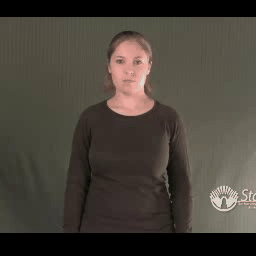

In [38]:
to_gif(sample_video)

### This is for feeding the data into the tensroflow pipeline.

In [16]:
class FrameGenerator:
    def __init__(self, path, n_frames, training = False):
        self.path = path
        self.n_frames = n_frames
        self.training = training
        self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
        self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

    def get_files_and_class_names(self):
        video_paths = list(self.path.glob('*/*.mp4'))
        classes = [p.parent.name for p in video_paths] 
        return video_paths, classes
    
    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()

        pairs = list(zip(video_paths, classes))

        if self.training:
            random.shuffle(pairs)

        for path, name in pairs:
            video_frames = Create_Frames(path, self.n_frames) 
            label = self.class_ids_for_name[name] # Encode labels
            yield video_frames, label

### Creating the splits and getting the generator set up

In [47]:
splits = {"train": .75, "val": 0.20, "test": 0.05}
base_dir = pathlib.Path('..\Data\Videos\wlasl-complete\ASL_subset')
subset_paths = Sort_Videos(splits,base_dir,files)

fg = FrameGenerator(subset_paths['train'], 10, training=True)

frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")

train
..\Data\Videos\wlasl-complete\ASL_subset\train\a\01612.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\a\01613.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\a\01615.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\a\01610.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\a lot\02123.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\a lot\02124.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\a lot\02125.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\a lot\02126.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\abdomen\00341.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\abdomen\00336.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\abdomen\00338.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\abdomen\00337.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\able\00381.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\able\00374.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\able\00377.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\able\00384.mp

..\Data\Videos\wlasl-complete\ASL_subset\train\adverb\01266.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\adverb\01263.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\adverb\01268.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\adverb\01269.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\affect\01323.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\affect\01325.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\affect\01321.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\affect\01319.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\afraid\01372.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\afraid\01379.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\afraid\01374.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\afraid\01375.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\africa\65029.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\africa\01384.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\africa\01386.mp4
..\Data\Videos\wlasl-complete\ASL_subset

..\Data\Videos\wlasl-complete\ASL_subset\train\alone\02110.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\alone\02104.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\alone\02108.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\alone\02109.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\alone\02106.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\alone\02112.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\alone\02107.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\alphabet\02146.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\alphabet\02145.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\alphabet\02151.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\alphabet\02150.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\alphabet\02149.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\already\02161.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\already\02165.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\already\02167.mp4
..\Data\Videos\wlasl-complete\ASL_

..\Data\Videos\wlasl-complete\ASL_subset\train\apostrophe\02915.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\apostrophe\02911.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\appear\02956.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\appear\02961.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\appear\02955.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\appear\02951.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\appear\02952.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\appear\67366.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\appetite\02973.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\appetite\02971.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\appetite\02969.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\appetite\02975.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\apple\67367.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\apple\03003.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\apple\02997.mp4
..\Data\Videos\wlasl-comple

..\Data\Videos\wlasl-complete\ASL_subset\train\asl\03625.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\asl\68266.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\asl\68005.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\assist\03766.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\assist\03769.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\assist\03750.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\assist\03771.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\assistant\03760.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\assistant\03763.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\assistant\03756.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\assistant\03761.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\assume\03802.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\assume\03804.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\assume\03805.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\assume\03800.mp4
..\Data\Videos\wlasl-complete\ASL_sub

..\Data\Videos\wlasl-complete\ASL_subset\train\baby\04513.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\baby\04511.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\baby\04484.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\baby\04514.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\baby\04510.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\babysitter\04530.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\babysitter\04537.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\babysitter\04534.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\babysitter\04535.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\back\04601.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\back\04593.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\back\04602.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\back\04596.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\back\67379.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\back\04597.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train

..\Data\Videos\wlasl-complete\ASL_subset\train\basketball\05236.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\basketball\05234.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\bath\05280.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\bath\05283.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\bath\05285.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\bath\05284.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\bath\05279.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\bath\05281.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\bath\67393.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\bathroom\05308.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\bathroom\05303.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\bathroom\05297.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\bathroom\05307.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\bathroom\67394.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\bathroom\65148.mp4
..\Data\Videos\wlasl-complete\ASL_

..\Data\Videos\wlasl-complete\ASL_subset\train\below\05915.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\belt\65173.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\belt\05924.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\belt\05926.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\belt\05923.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\belt\67407.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\belt\05930.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\benefit\05964.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\benefit\05963.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\benefit\65175.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\benefit\05959.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\benefit\05965.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\benefit\05962.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\berry\05986.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\berry\05988.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\be

..\Data\Videos\wlasl-complete\ASL_subset\train\bless\06626.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\bless\06628.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\bless\06625.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\bless\65206.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\blind\06649.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\blind\06655.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\blind\06657.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\blind\06643.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\blind\06650.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\blind\06658.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\blind\06654.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\blood\67418.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\blood\06735.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\blood\06736.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\blood\65212.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\blood\06

..\Data\Videos\wlasl-complete\ASL_subset\train\bowling\65242.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\bowling\07402.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\bowling\07396.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\bowling\07395.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\bowling\07403.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\bowling\07394.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\bowling\07400.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\box\07422.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\box\70238.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\box\07418.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\box\07421.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\box\65244.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\box\07417.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\box\07413.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\boxing\07430.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\boxing\

..\Data\Videos\wlasl-complete\ASL_subset\train\brown\07973.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\brown\69252.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\brown\69028.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\brush\67447.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\brush\65264.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\brush\08007.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\brush\08001.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\brush\65265.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\buffalo\08088.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\buffalo\08094.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\buffalo\08091.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\buffalo\08089.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\bug\08107.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\bug\08114.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\bug\08111.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\bug\08

..\Data\Videos\wlasl-complete\ASL_subset\train\call\67460.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\call\08697.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\call\08692.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\call\08694.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\call\08691.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\call\65556.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\calm\08745.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\calm\08746.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\calm\08751.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\calm\08749.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\calm\08750.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\calm\08748.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\camel\08774.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\camel\08780.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\camel\08778.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\camel\08772.mp4
..\D

..\Data\Videos\wlasl-complete\ASL_subset\train\cat\09528.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\cat\09536.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\cat\09526.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\cat\09533.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\cat\09537.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\cat\09532.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\catch\09463.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\catch\09458.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\catch\09473.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\catch\09467.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\catch\09457.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\catch\09459.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\catch\09470.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\category\09487.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\category\09490.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\category\09488

..\Data\Videos\wlasl-complete\ASL_subset\train\cheap\10141.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\cheap\10135.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\cheap\10144.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\cheap\10143.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\cheat\10162.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\cheat\10164.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\cheat\10157.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\cheat\10160.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\cheat\10148.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\cheat\10151.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\cheat\67489.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\cheat\10166.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\cheat\10149.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\check\10185.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\check\10190.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\check\10

..\Data\Videos\wlasl-complete\ASL_subset\train\circle\65360.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\city\10904.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\city\10895.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\city\10893.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\city\10888.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\city\10892.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\city\10903.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\city\65362.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\city\65363.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\city\67501.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\class\10968.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\class\65364.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\class\10976.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\class\10975.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\class\10969.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\class\10970.mp4


..\Data\Videos\wlasl-complete\ASL_subset\train\cold\11622.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\collect\11692.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\collect\11688.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\collect\11693.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\collect\11689.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\college\11709.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\college\11708.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\college\11716.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\college\11714.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\college\68026.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\college\11704.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\college\11713.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\college\11718.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\color\11780.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\color\11752.mp4
..\Data\Videos\wlasl-complete\AS

..\Data\Videos\wlasl-complete\ASL_subset\train\concern\65393.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\concern\12415.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\concern\12418.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\conflict\12592.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\conflict\12593.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\conflict\12590.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\conflict\12586.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\conflict\12588.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\conflict\65394.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\confront\12609.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\confront\12605.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\confront\12604.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\confront\12602.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\confused\65395.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\confused\12618.mp4
..\Data\Video

..\Data\Videos\wlasl-complete\ASL_subset\train\corn\13329.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\corn\13323.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\corn\69282.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\corn\13330.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\corn\13328.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\corn\13325.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\corn\13335.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\corner\13311.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\corner\70181.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\corner\65407.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\corner\13316.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\corner\13319.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\corner\13315.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\correct\65410.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\correct\13357.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\corre

..\Data\Videos\wlasl-complete\ASL_subset\train\cry\14172.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\cry\14176.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\cry\14178.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\cuba\14202.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\cuba\14205.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\cuba\14209.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\cuba\14204.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\culture\14254.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\culture\14267.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\culture\14261.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\culture\14266.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\culture\14263.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\cup\14287.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\cup\14288.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\cup\14276.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\cup\14296.mp4


..\Data\Videos\wlasl-complete\ASL_subset\train\deaf\70015.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\deaf\14898.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\deaf\14882.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\deaf\65445.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\deaf\14903.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\deaf\14884.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\deaf\14900.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\deaf\14895.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\deaf\14888.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\death\14953.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\death\14954.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\death\14955.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\death\14952.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\debate\14966.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\debate\14965.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\debate\14960.mp

..\Data\Videos\wlasl-complete\ASL_subset\train\deposit\15632.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\deposit\15635.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\deposit\15631.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\depressed\15648.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\depressed\15649.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\depressed\15651.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\depressed\65466.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\descend\15702.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\descend\15696.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\descend\15691.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\descend\15704.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\describe\15707.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\describe\15708.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\describe\15705.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\describe\15712.mp4
..\Data\Video

..\Data\Videos\wlasl-complete\ASL_subset\train\diploma\16350.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\diploma\16355.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\diploma\16352.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\diploma\16357.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\diploma\16358.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\director\65484.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\director\16385.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\director\16384.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\director\16387.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\director\16388.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\dirt\16399.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\dirt\16394.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\dirt\16400.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\dirt\70374.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\dirty\16410.mp4
..\Data\Videos\wlasl-complete\ASL_

..\Data\Videos\wlasl-complete\ASL_subset\train\dollar\17135.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\dollar\17126.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\dollar\17123.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\dolphin\17163.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\dolphin\17164.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\dolphin\17157.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\dolphin\17158.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\dolphin\17166.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\don't want\17300.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\don't want\17303.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\don't want\68037.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\don't want\17306.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\don't want\17301.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\done\17214.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\done\17209.mp4
..\Data\Videos\wlas

..\Data\Videos\wlasl-complete\ASL_subset\train\drunk\17910.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\dry\17939.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\dry\17919.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\dry\65549.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\dry\17933.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\dry\17934.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\dry\17938.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\dry\17931.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\duck\17945.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\duck\67600.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\duck\17955.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\duck\17951.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\duck\65551.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\duck\69305.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\due\17958.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\due\17959.mp4
..\Data\Videos\w

..\Data\Videos\wlasl-complete\ASL_subset\train\educate\18418.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\educate\18420.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\educate\18417.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\educate\18421.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\education\18426.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\education\18429.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\education\18424.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\education\18430.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\effort\18480.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\effort\18478.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\effort\18479.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\effort\18482.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\egg\18487.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\egg\67612.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\egg\18498.mp4
..\Data\Videos\wlasl-complete\ASL

..\Data\Videos\wlasl-complete\ASL_subset\train\enjoy\19264.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\enjoy\70051.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\enjoy\19257.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\enjoy\19269.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\enjoy\19255.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\enjoy\19267.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\enjoy\19258.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\enormous\19302.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\enormous\19301.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\enormous\19303.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\enormous\19297.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\enough\19312.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\enough\19309.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\enough\19306.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\enough\19304.mp4
..\Data\Videos\wlasl-complete\ASL_subse

..\Data\Videos\wlasl-complete\ASL_subset\train\exchange\20142.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\exchange\20145.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\exchange\20149.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\excited\20160.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\excited\20153.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\excited\20162.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\excited\20157.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\excited\20152.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\excited\20159.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\excuse\20199.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\excuse\20198.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\excuse\20202.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\excuse\20203.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\excuse\67633.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\exercise\20228.mp4
..\Data\Videos\wlasl-compl

..\Data\Videos\wlasl-complete\ASL_subset\train\family\20980.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\family\67642.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\family\20979.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\family\69316.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\famous\21015.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\famous\21011.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\famous\21012.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\famous\65678.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\famous\21008.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\fancy\65680.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\fancy\21022.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\fancy\21026.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\fancy\21027.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\fancy\21033.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\far\21076.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\f

..\Data\Videos\wlasl-complete\ASL_subset\train\find\21855.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\find\69323.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\find\21858.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\fine\67660.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\fine\21874.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\fine\21885.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\fine\21884.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\fine\68048.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\fine\21887.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\fine\21875.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\fine\21888.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\fine\70234.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\fine\67659.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\fine\65717.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\fingerspell\21923.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\fingerspell\2192

..\Data\Videos\wlasl-complete\ASL_subset\train\food\68052.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\food\22747.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\food\22739.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\food\22748.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\food\22743.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\fool\22775.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\fool\22774.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\fool\22772.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\fool\22780.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\football\22803.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\football\70129.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\football\22809.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\football\22802.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\football\22818.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\football\22815.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train

..\Data\Videos\wlasl-complete\ASL_subset\train\from now on\23646.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\from now on\23649.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\from now on\23651.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\front\23670.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\front\23664.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\front\67695.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\front\23672.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\front\70163.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\front\23665.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\fruit\65789.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\fruit\23703.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\fruit\23705.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\fruit\67696.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\fruit\23701.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\full\23769.mp4
..\Data\Videos\wlasl-complete\ASL_subs

..\Data\Videos\wlasl-complete\ASL_subset\train\get up\24501.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\ghost\24518.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\ghost\24520.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\ghost\24515.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\ghost\24514.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\ghost\24519.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\gift\24548.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\gift\24547.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\gift\24553.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\gift\24554.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\giraffe\24587.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\giraffe\24580.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\giraffe\24585.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\giraffe\24584.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\giraffe\24583.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\g

..\Data\Videos\wlasl-complete\ASL_subset\train\graduate\65843.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\graduate\25327.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\graduate\68528.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\graduate\67722.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\graduate\70176.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\graduate\25323.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\graduate\25333.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\graduate\25338.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\graduation\25352.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\graduation\25350.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\graduation\25351.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\graduation\25356.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\grammar\25372.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\grammar\25377.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\grammar\65845.mp4
..\Da

..\Data\Videos\wlasl-complete\ASL_subset\train\hair\26167.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\hair\26162.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\hair\65870.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\haircut\69062.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\haircut\26136.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\haircut\26141.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\haircut\26135.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\half\26224.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\half\26216.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\half\26214.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\half\26222.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\half\26203.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\halloween\26259.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\halloween\26252.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\halloween\26258.mp4
..\Data\Videos\wlasl-complete\ASL_subset\tr

..\Data\Videos\wlasl-complete\ASL_subset\train\heart\27055.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\heart\27053.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\heart\67752.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\heart\27056.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\heart\27044.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\heart attack\27017.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\heart attack\27022.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\heart attack\27018.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\heart attack\27023.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\heaven\27078.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\heaven\65887.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\heaven\27079.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\heaven\27082.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\heaven\27085.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\heavy\27098.mp4
..\Data\Videos\wlasl-c

..\Data\Videos\wlasl-complete\ASL_subset\train\honey\65899.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\honey\27849.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\honey\27840.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\honey\27848.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\honor\27879.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\honor\27877.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\honor\27874.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\honor\27881.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\honor\67768.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\hop\27943.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\hop\27941.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\hop\27940.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\hop\27915.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\hope\27931.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\hope\27929.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\hope\27932.mp4
..\

..\Data\Videos\wlasl-complete\ASL_subset\train\identify\28683.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\identify\28681.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\identify\28678.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\identify\28675.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\if\28739.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\if\28737.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\if\69375.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\if\28748.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\if\28736.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\ignore\67784.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\ignore\28779.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\ignore\28778.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\ignore\28783.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\ignore\28777.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\ignore\28782.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\ill\2

..\Data\Videos\wlasl-complete\ASL_subset\train\insurance\30059.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\interest\30155.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\interest\30158.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\interest\30162.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\interest\65950.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\interest\30152.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\interest\30160.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\interest\30166.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\interest\30163.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\interesting\30172.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\interesting\68308.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\interesting\30175.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\interesting\30169.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\interesting\30180.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\international

..\Data\Videos\wlasl-complete\ASL_subset\train\jesus\31055.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\jesus\31049.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\jesus\31056.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\jesus\31053.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\jesus\31057.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\jewelry\31079.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\jewelry\31082.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\jewelry\31077.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\jewelry\31080.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\jewish\65979.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\jewish\31097.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\jewish\31094.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\jewish\31095.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\jewish\31092.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\join\31147.mp4
..\Data\Videos\wlasl-complete\ASL_subset\tr

..\Data\Videos\wlasl-complete\ASL_subset\train\know\31902.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\know\31896.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\know\31900.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\know\31899.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\know\31907.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\know\31908.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\label\31978.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\label\31984.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\label\31983.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\label\31975.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\label\31976.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\lady\32047.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\lady\32046.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\lady\32052.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\lady\32051.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\lamp\32104.mp4
..\

..\Data\Videos\wlasl-complete\ASL_subset\train\learn\32610.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\learn\32616.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\learn\32612.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\learn\66024.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\learn\67835.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\leave\32677.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\leave\32663.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\leave\32675.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\leave\32657.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\leave\32661.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\leave\67836.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\leave\32655.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\leave\32659.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\lecture\32698.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\lecture\32697.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\lect

..\Data\Videos\wlasl-complete\ASL_subset\train\lion\33392.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\lion\33396.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\lion\33390.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\lion\33393.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\lion\33395.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\lion\67849.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\lip\33404.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\lip\33402.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\lip\33407.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\lip\33409.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\lipstick\33423.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\lipstick\33429.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\lipstick\33424.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\lipstick\33425.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\list\67852.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\list\33479.

..\Data\Videos\wlasl-complete\ASL_subset\train\mainstream\34512.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\mainstream\34510.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\mainstream\34511.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\mainstream\34514.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\major\68097.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\major\34548.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\major\34549.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\major\34547.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\major\34543.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\make\34579.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\make\34582.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\make\34577.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\make\34575.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\make\34583.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\make\34578.mp4
..\Data\Videos\wlasl-complete\ASL_subset\

..\Data\Videos\wlasl-complete\ASL_subset\train\meet\35515.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\meet\35520.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\meet\66112.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\meet\35514.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\meet\35512.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\meeting\35528.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\meeting\35529.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\meeting\35526.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\meeting\35530.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\meeting\35531.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\meeting\35524.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\meeting\35532.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\melody\35558.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\melody\35559.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\melody\35557.mp4
..\Data\Videos\wlasl-complete\ASL_subset\tr

..\Data\Videos\wlasl-complete\ASL_subset\train\monday\36630.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\monday\70023.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\money\68628.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\money\36648.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\money\36657.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\money\36654.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\money\36658.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\money\36652.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\money\36653.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\monkey\36685.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\monkey\36681.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\monkey\36680.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\monkey\66140.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\monkey\36677.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\monkey\67902.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\

..\Data\Videos\wlasl-complete\ASL_subset\train\murder\37308.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\murder\37310.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\murder\37302.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\murder\37309.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\muscle\37315.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\muscle\37316.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\muscle\37313.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\muscle\37318.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\muscle\37317.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\muscle\37314.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\museum\37339.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\museum\37341.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\museum\68286.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\museum\37333.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\museum\37338.mp4
..\Data\Videos\wlasl-complete\ASL_subset

..\Data\Videos\wlasl-complete\ASL_subset\train\neutral\67928.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\neutral\38067.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\never\38092.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\never\70038.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\never\38090.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\never\38084.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\never\67927.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\never\38081.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\never\38086.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\new\67929.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\new\38125.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\new\38126.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\new\38128.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\new\38131.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\new\69407.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\new\38127.mp4
..

..\Data\Videos\wlasl-complete\ASL_subset\train\now\39000.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\now\39005.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\now\38994.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\now\38997.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\number\39035.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\number\39037.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\number\68117.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\number\39033.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\number\68824.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\number\39036.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\numerous\39072.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\numerous\39069.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\numerous\39071.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\numerous\39070.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\nun\39080.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\

..\Data\Videos\wlasl-complete\ASL_subset\train\onion\39857.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\onion\67946.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\onion\39852.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\only\39879.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\only\39877.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\only\39881.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\only\39878.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\only\39876.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\open\39956.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\open\39953.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\open\39955.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\open\39954.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\open\39952.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\operate\39986.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\operate\39994.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\operate\39990.

..\Data\Videos\wlasl-complete\ASL_subset\train\pants\68126.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pants\40992.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pants\40990.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pants\40988.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\paper\68446.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\paper\41026.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\paper\68127.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\paper\41036.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\paper\70211.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\paper\41035.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\paper\41031.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\paper\41028.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\paper\41025.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\parachute\41060.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\parachute\41055.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\

..\Data\Videos\wlasl-complete\ASL_subset\train\pepper\67975.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pepper\41938.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pepper\41941.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pepper\41939.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pepper\41940.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pepper\41937.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pepper\41945.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\percent\41978.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\percent\41979.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\percent\41981.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\percent\41977.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\percent\67977.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\perfect\65575.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\perfect\42003.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\perfect\67979.mp4
..\Data\Videos\wlasl-complete\AS

..\Data\Videos\wlasl-complete\ASL_subset\train\pink\67990.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pink\69430.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pink\42832.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pity\42940.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pity\42946.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pity\67992.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pity\42939.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pizza\42960.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pizza\42976.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pizza\69431.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pizza\42959.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pizza\42961.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pizza\42971.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pizza\42977.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pizza\42972.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pizza\42958.mp4

..\Data\Videos\wlasl-complete\ASL_subset\train\positive\43813.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\positive\43812.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\positive\43811.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\positive\43809.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\positive\43814.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\possible\43831.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\possible\43833.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\possible\43834.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\possible\43838.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\possible\43830.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\possible\66316.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\possible\67092.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\post\43880.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\post\43876.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\post\43873.mp4
..\Data\Videos\wlasl-c

..\Data\Videos\wlasl-complete\ASL_subset\train\president\66326.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\president\44373.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\president\44374.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\president\44372.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\president\44364.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pressure\44402.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pressure\44397.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pressure\44400.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pressure\44394.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pretty\44422.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pretty\44428.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pretty\44429.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pretty\44426.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pretty\66328.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\pretty\69437.mp4
..\Data\Videos\wl

..\Data\Videos\wlasl-complete\ASL_subset\train\proper\44971.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\proper\44974.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\proper\44975.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\prostitute\45055.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\prostitute\45056.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\prostitute\45057.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\prostitute\45052.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\protect\45064.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\protect\45066.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\protect\45060.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\protect\45061.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\protect\45065.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\proud\45089.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\proud\45091.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\proud\45092.mp4
..\Data\Videos\wlasl-c

..\Data\Videos\wlasl-complete\ASL_subset\train\quiet\45760.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\quit\45788.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\quit\45787.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\quit\45786.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\quit\45782.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\quit\45789.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\quit\45784.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\quote\45822.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\quote\45825.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\quote\45820.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\quote\45823.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\r\47985.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\r\45829.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\r\47984.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\r\47983.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\rabbit\45845.mp4
..\Data\Video

..\Data\Videos\wlasl-complete\ASL_subset\train\reduce\46761.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\reduce\46762.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\reduce\46754.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\reduce\46752.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\refer\46793.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\refer\46792.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\refer\46794.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\refer\46796.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\referee\46774.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\referee\46780.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\referee\46783.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\referee\46778.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\refuse\46870.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\refuse\46869.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\refuse\66381.mp4
..\Data\Videos\wlasl-complete\ASL_subset

..\Data\Videos\wlasl-complete\ASL_subset\train\respect\47615.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\respect\47610.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\respect\47605.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\respect\47606.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\responsibility\67137.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\responsibility\47643.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\responsibility\47640.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\responsibility\47644.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\responsible\47647.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\responsible\47646.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\responsible\47645.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\responsible\47649.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\rest\47673.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\rest\67138.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\rest\

..\Data\Videos\wlasl-complete\ASL_subset\train\roof\48494.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\room\48521.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\room\48515.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\room\48511.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\room\48520.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\room\48514.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\room\67149.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\room\48516.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\room\66415.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\room\48512.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\roommate\48525.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\roommate\48524.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\roommate\66417.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\roommate\48526.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\rooster\48538.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\roos

..\Data\Videos\wlasl-complete\ASL_subset\train\sauce\49343.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\sauce\49345.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\sausage\49364.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\sausage\49365.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\sausage\49362.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\sausage\49358.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\save\49382.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\save\49377.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\save\49376.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\save\49381.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\save\49367.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\save\49372.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\save\49378.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\saw\67163.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\saw\49418.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\saw\49412.m

..\Data\Videos\wlasl-complete\ASL_subset\train\selfish\50250.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\selfish\50245.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\selfish\50249.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\selfish\50247.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\selfish\50243.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\sell\50269.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\sell\69461.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\sell\50266.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\sell\68830.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\sell\50273.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\sell\50272.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\senate\50317.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\senate\50316.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\senate\50321.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\senate\50320.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\

..\Data\Videos\wlasl-complete\ASL_subset\train\shirt\51054.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\shirt\51077.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\shirt\51063.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\shirt\51066.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\shock\51106.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\shock\51094.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\shock\66466.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\shock\51112.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\shock\51114.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\shock\51102.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\shoes\68150.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\shoes\51139.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\shoes\51134.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\shoes\51131.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\shoes\51140.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\shoes\51

..\Data\Videos\wlasl-complete\ASL_subset\train\since\67204.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\since\51776.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\since\70351.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\since\51780.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\since\51775.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\sing\51804.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\sing\51810.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\sing\51808.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\sing\51807.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\sing\51805.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\singer\51801.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\singer\51798.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\singer\51797.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\singer\51800.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\single\51820.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\single\5

..\Data\Videos\wlasl-complete\ASL_subset\train\slow\52502.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\slow\52514.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\slow\52506.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\small\52556.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\small\52550.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\small\52565.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\small\52554.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\small\52555.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\small\52562.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\small\52551.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\small\67214.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\smart\52579.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\smart\52576.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\smart\52583.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\smart\52588.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\smart\52575

..\Data\Videos\wlasl-complete\ASL_subset\train\sometimes\53241.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\sometimes\70035.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\sometimes\53243.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\sometimes\53245.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\sometimes\53246.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\somewhere\53254.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\somewhere\53255.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\somewhere\53256.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\somewhere\53252.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\son\66532.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\son\67227.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\son\53272.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\son\53268.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\son\53275.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\son\53270.mp4
..\Data\Videos\wlasl-complete\A

..\Data\Videos\wlasl-complete\ASL_subset\train\spray\54077.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\spray\54074.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\spray\54076.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\spray\54082.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\spray\54080.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\spray\54069.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\spread\54090.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\spread\54092.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\spread\54094.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\spread\54093.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\spring\54116.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\spring\54121.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\spring\54117.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\spring\54118.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\sprint\54141.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train

..\Data\Videos\wlasl-complete\ASL_subset\train\stop\54929.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\stop\54931.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\store\54955.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\store\54963.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\store\54965.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\store\54966.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\store\54957.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\story\55002.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\story\54995.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\story\66561.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\story\54999.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\story\55000.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\story\54997.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\straight\55052.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\straight\55044.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\stra

..\Data\Videos\wlasl-complete\ASL_subset\train\summer\55730.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\summer\55737.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\summer\55734.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\summer\55736.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\summer\66579.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\summon\55750.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\summon\55745.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\summon\55747.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\summon\55746.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\summon\55748.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\summon\55749.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\sun\55804.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\sun\55808.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\sun\67261.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\sun\55807.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\sun\5

..\Data\Videos\wlasl-complete\ASL_subset\train\swing\56390.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\swing\56389.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\swing\56394.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\swing\67273.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\swing\56391.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\switzerland\56424.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\switzerland\56429.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\switzerland\56422.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\switzerland\56425.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\switzerland\56427.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\symbol\56465.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\symbol\56462.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\symbol\56468.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\symbol\56469.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\symbol\56461.mp4
..\Data\Videos\wlasl

..\Data\Videos\wlasl-complete\ASL_subset\train\television\57268.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\television\57261.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\television\57267.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\television\57264.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\television\57269.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\television\57266.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tell\57279.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tell\57282.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tell\57284.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tell\57291.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tell\57283.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tell\57285.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tell\57290.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tell\67287.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tell\57278.mp4
..\Data\Videos\wlasl-complete\ASL_

..\Data\Videos\wlasl-complete\ASL_subset\train\then\68550.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\then\57769.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\theory\57786.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\theory\66603.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\theory\57782.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\theory\57792.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\theory\57787.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\theory\57791.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\theory\66604.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\theory\57785.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\therapy\57812.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\therapy\57809.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\therapy\57807.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\therapy\57804.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\therapy\57803.mp4
..\Data\Videos\wlasl-complete\ASL_subse

..\Data\Videos\wlasl-complete\ASL_subset\train\time\67309.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\time\68294.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\time\58497.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\time\58503.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\time\68171.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tiptoe\58574.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tiptoe\58581.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tiptoe\58579.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tiptoe\58578.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tiptoe\58580.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tired\58592.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tired\58594.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tired\58599.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tired\58593.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tired\58597.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tired\58

..\Data\Videos\wlasl-complete\ASL_subset\train\tournament\67318.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tournament\59110.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tournament\59107.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\towel\59120.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\towel\59122.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\towel\59123.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\towel\59125.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tower\59138.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tower\59135.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tower\59131.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tower\59137.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\town\59155.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\town\59148.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\town\59146.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\town\59143.mp4
..\Data\Videos\wlasl-complete\ASL_subset\tra

..\Data\Videos\wlasl-complete\ASL_subset\train\turtle\60044.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\turtle\60046.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\turtle\60045.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tutor\60060.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tutor\60064.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tutor\60056.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tutor\60058.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tv\60074.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tv\69520.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tv\60072.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\tv\67329.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\twin\60164.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\twin\60157.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\twin\60155.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\twin\60162.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\two\60223.mp4
..\Data

..\Data\Videos\wlasl-complete\ASL_subset\train\vegetable\61366.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\vegetable\67025.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\verb\61444.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\verb\67026.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\verb\61449.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\verb\61439.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\verb\61442.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\very\61511.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\very\61509.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\very\61515.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\very\61512.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\vice president\61592.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\vice president\61588.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\vice president\61595.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\vice president\61591.mp4
..\Data\Videos\wlasl

..\Data\Videos\wlasl-complete\ASL_subset\train\war\67039.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\war\62283.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\war\62279.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\war\62267.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\war\62275.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\war\62284.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\war\62280.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\warm\62290.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\warm\62289.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\warm\62291.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\warm\62294.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\warm\62296.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\warm\62297.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\warn\62309.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\warn\67040.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\warn\62304.mp4
..\Data\Videos\

..\Data\Videos\wlasl-complete\ASL_subset\train\welcome\62832.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\welcome\66763.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\welcome\62829.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\welcome\62836.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\welcome\62835.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\west\67055.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\west\62908.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\west\62909.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\west\62915.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\west\62910.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\west\62907.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\west\70186.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\wet\62922.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\wet\69529.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\wet\62926.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\wet\62929.m

..\Data\Videos\wlasl-complete\ASL_subset\train\wind\66790.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\wind\70086.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\wind\63404.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\window\63417.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\window\66791.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\window\63421.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\window\63418.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\window\67069.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\window\63424.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\window\68184.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\window\63425.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\wine\63454.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\wine\63451.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\wine\63450.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\wine\63453.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\wine\63

..\Data\Videos\wlasl-complete\ASL_subset\train\wrap\63972.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\wrap\63978.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\wrench\64012.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\wrench\64001.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\wrench\64006.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\wrench\64011.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\wrench\64003.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\wristwatch\64046.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\wristwatch\64041.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\wristwatch\64048.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\wristwatch\64043.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\wristwatch\64045.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\write\64068.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\write\64057.mp4
..\Data\Videos\wlasl-complete\ASL_subset\train\write\66815.mp4
..\Data\Videos\wlasl-comple

..\Data\Videos\wlasl-complete\ASL_subset\val\add\69205.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\add\00973.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\address\01011.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\address\01024.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\adjective\01067.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\adjective\01066.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\adjust\01073.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\adjust\01077.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\admire\01101.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\admire\01102.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\admit\01127.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\admit\65021.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\adopt\01158.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\adopt\01149.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\adult\01209.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\adult\01208.mp4
..\Data\Vide

..\Data\Videos\wlasl-complete\ASL_subset\val\anniversary\02616.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\announce\02625.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\announce\02621.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\announce\65074.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\annoy\02652.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\annoy\02653.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\another\02702.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\another\02705.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\answer\02715.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\answer\02716.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\answer\70275.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\any\02830.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\any\02831.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\any\02826.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\anyway\02852.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\anyway\02850.mp4
..\Dat

..\Data\Videos\wlasl-complete\ASL_subset\val\author\04216.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\authority\04227.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\authority\04230.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\autumn\04293.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\autumn\04291.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\autumn\04292.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\available\04300.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\available\04307.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\average\04324.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\average\04329.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\avoid\04351.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\avoid\04350.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\avoid\04341.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\awake\04356.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\awake\04355.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\award\04367.mp4


..\Data\Videos\wlasl-complete\ASL_subset\val\beg\05766.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\beg\05761.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\beginning\05784.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\beginning\05778.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\behavior\05797.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\behavior\05798.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\behind\05808.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\behind\67404.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\behind\05813.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\behind\05809.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\belief\05851.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\belief\05850.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\believe\67405.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\believe\05852.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\believe\05856.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\bell\05875.mp4
..\

..\Data\Videos\wlasl-complete\ASL_subset\val\borrow\65230.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\borrow\07231.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\boss\07247.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\boss\67428.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\boss\07236.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\both\07258.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\both\07277.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\both\65233.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\bother\07269.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\bother\65234.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\bother\07265.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\bottle\69243.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\bottle\07288.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\bottle\07289.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\bottom\07306.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\bottom\07299.mp4
..\Data\Videos\wlasl

..\Data\Videos\wlasl-complete\ASL_subset\val\calculator\08634.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\calculus\08642.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\calculus\08644.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\california\08676.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\california\65289.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\california\08679.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\call\08713.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\call\08695.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\call\08690.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\call\08698.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\calm\08754.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\calm\08752.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\calm\08755.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\camel\08773.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\camel\08779.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\camera\08786.mp4
..\D

..\Data\Videos\wlasl-complete\ASL_subset\val\chat\10108.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\cheap\10140.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\cheap\10142.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\cheap\10137.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\cheat\10156.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\cheat\10147.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\cheat\10159.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\cheat\67490.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\cheat\10146.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\check\10183.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\check\10196.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\check\10186.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\check\10194.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\cheerleader\10249.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\cheerleader\10252.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\cheese\10270.mp4
..\Data\Vide

..\Data\Videos\wlasl-complete\ASL_subset\val\college\67512.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\color\11779.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\color\68202.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\color\11767.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\color\67514.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\color\11776.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\comb\11828.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\comb\11819.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\comb\11820.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\come\69275.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\come\11876.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\come here\11864.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\come here\11862.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\comfortable\11908.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\comfortable\11900.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\comfortable\11906.mp4
.

..\Data\Videos\wlasl-complete\ASL_subset\val\cop\13245.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\cop\13250.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\cop\13249.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\copy\65405.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\copy\13271.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\copy\13269.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\copy\13278.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\corn\13334.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\corn\13331.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\corn\67531.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\corn\13337.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\corn\65408.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\corner\13314.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\corner\13317.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\corner\13312.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\correct\13354.mp4
..\Data\Videos\wlasl-complete\ASL_

..\Data\Videos\wlasl-complete\ASL_subset\val\deaf\68033.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\deaf\14886.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\deaf\14889.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\deaf\14885.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\death\67554.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\death\14956.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\debate\14968.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\debate\14967.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\debt\14981.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\debt\14982.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\december\15022.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\december\15025.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\decide\15040.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\decide\15031.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\decide\70119.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\decide\65450.mp4
..\Data\Videos\wla

..\Data\Videos\wlasl-complete\ASL_subset\val\disagree\16434.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\disagree\16430.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\disappear\67574.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\disappear\16443.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\disappear\16450.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\disappear\16439.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\discipline\16504.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\discipline\16511.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\disconnect\16525.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\disconnect\16531.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\discount\16542.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\discount\16545.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\discover\16569.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\discover\16563.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\discuss\16594.mp4
..\Data\Videos\wlasl-complete

..\Data\Videos\wlasl-complete\ASL_subset\val\duty\18058.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\duty\18063.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\dvd\18075.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\dvd\18072.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\dye\18090.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\dye\18092.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\e\18534.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\e\66043.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\each\18110.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\each\18109.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\eagle\18137.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\eagle\18141.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\eagle\18139.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\ear\18145.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\ear\65591.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\ear\18155.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\early

..\Data\Videos\wlasl-complete\ASL_subset\val\eternity\19657.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\eternity\19660.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\europe\67631.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\europe\19688.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\europe\19689.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\evaluate\19705.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\evaluate\19713.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\evaluate\19704.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\evening\19742.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\evening\19739.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\event\19760.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\event\19762.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\event\19769.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\every\19847.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\every\65648.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\every\19843.mp4
..

..\Data\Videos\wlasl-complete\ASL_subset\val\fear\21328.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\fear\21334.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\fear\21330.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\february\21355.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\february\21360.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\federal\21371.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\federal\21374.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\feed\21408.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\feed\21417.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\feed\21414.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\feedback\21404.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\feedback\21397.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\feedback\21395.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\feel\21434.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\feel\21433.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\feel\67653.mp4
..\Data\Videos

..\Data\Videos\wlasl-complete\ASL_subset\val\france\23336.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\france\67684.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\france\23330.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\free\23395.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\free\23415.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\freeway\23425.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\freeway\23434.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\freeze\23447.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\freeze\23444.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\freeze\23450.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\french\68822.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\french\67688.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\french\23485.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\french fries\65780.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\french fries\23473.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\friday\65781.mp

..\Data\Videos\wlasl-complete\ASL_subset\val\goal\24868.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\goal\24881.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\goat\65830.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\goat\24888.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\goat\24889.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\god\65832.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\god\24918.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\god\24916.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\gold\24997.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\gold\24978.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\golf\25016.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\golf\25013.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\golf\25017.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\gone\25034.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\gone\25025.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\gone\65834.mp4
..\Data\Videos\wlasl-complete\ASL_subset\va

..\Data\Videos\wlasl-complete\ASL_subset\val\hawaii\26800.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\hawaii\26802.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\hawaii\26806.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\head\26858.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\head\26856.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\head\69362.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\headache\26833.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\headache\26837.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\headache\26838.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\headache\26836.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\health\26916.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\health\26919.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\heap\26931.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\heap\65883.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\hear\26953.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\hear\26943.mp4
..\Data\Videos

..\Data\Videos\wlasl-complete\ASL_subset\val\human\28285.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\human\28291.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\humble\28312.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\humble\28319.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\humble\28318.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\humble\28316.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\hungry\28385.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\hungry\28384.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\hungry\28379.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\hunt\28395.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\hunt\67780.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\hurricane\28417.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\hurricane\28415.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\hurry\68616.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\hurry\70236.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\hurry\28435.mp4
..\Data\Vid

..\Data\Videos\wlasl-complete\ASL_subset\val\involve\30526.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\involve\30525.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\iran\30562.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\iran\30559.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\ireland\30584.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\ireland\30587.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\iron\30601.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\iron\67798.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\island\30682.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\island\30678.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\island\65966.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\israel\30715.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\israel\30706.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\israel\67800.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\italy\30745.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\italy\65969.mp4
..\Data\Videos

..\Data\Videos\wlasl-complete\ASL_subset\val\late\32311.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\late\32307.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\later\32319.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\later\32323.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\later\32321.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\later\32329.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\later\32338.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\laugh\66016.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\laugh\32381.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\laugh\32377.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\laugh\32379.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\laundry\32426.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\laundry\32419.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\law\32453.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\law\32448.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\law\32451.mp4
..\Data\Videos\wlasl-complet

..\Data\Videos\wlasl-complete\ASL_subset\val\lonely\33767.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\lonely\33770.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\long\33806.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\long\33808.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\look at\33848.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\look at\33855.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\look for\67860.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\look for\33881.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\lord\33981.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\lord\33985.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\loud\34086.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\loud\34095.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\loud\34094.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\lousy\34114.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\lousy\34109.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\lousy\34115.mp4
..\Data\Videos\wlas

..\Data\Videos\wlasl-complete\ASL_subset\val\middle\35972.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\middle\35965.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\midnight\35992.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\midnight\35991.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\military\36036.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\military\36039.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\milk\36055.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\milk\68100.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\milk\36047.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\milk\36052.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\mind\36118.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\mind\36123.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\mine\36140.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\mine\36142.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\minus\68101.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\minus\36238.mp4
..\Data\Videos\wla

..\Data\Videos\wlasl-complete\ASL_subset\val\n\66052.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\name\37589.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\name\37583.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\name\37590.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\name\37584.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\napkin\37613.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\napkin\37615.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\napkin\66159.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\narrow\37652.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\narrow\37644.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\nation\37685.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\nation\37669.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\near\37796.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\near\37791.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\near\37773.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\near\37795.mp4
..\Data\Videos\wlasl-complete

..\Data\Videos\wlasl-complete\ASL_subset\val\objective\39202.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\obsess\39255.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\obsess\39256.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\obtain\39291.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\obtain\39286.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\occur\39333.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\occur\39335.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\ocean\39354.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\ocean\39351.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\october\39365.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\october\39361.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\octopus\39375.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\octopus\69417.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\odd\39377.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\odd\39378.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\odor\39387.mp4
..\Data\Video

..\Data\Videos\wlasl-complete\ASL_subset\val\parents\41166.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\part\41256.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\part\41266.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\party\41311.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\party\41321.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\party\41315.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\party\41318.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\pass\41354.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\pass\41350.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\pass\41361.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\past\41449.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\past\41456.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\past\41455.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\past\70151.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\path\41487.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\path\41484.mp4
..\Data\Videos\wlasl-complete\ASL

..\Data\Videos\wlasl-complete\ASL_subset\val\plant\43090.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\plant\43087.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\plate\43114.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\plate\43120.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\play\68288.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\play\43167.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\play\43168.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\play\43171.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\play\43170.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\player\43146.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\player\43148.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\please\43224.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\please\43226.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\please\43213.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\please\69434.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\plenty\43257.mp4
..\Data\Videos\wlasl-c

..\Data\Videos\wlasl-complete\ASL_subset\val\pride\44490.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\priest\44496.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\priest\44499.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\priest\44495.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\prince\44522.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\prince\44529.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\princess\44534.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\princess\44537.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\principal\44541.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\principal\44543.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\principle\44553.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\principle\44555.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\print\44567.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\print\44570.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\print\66332.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\printer\44558

..\Data\Videos\wlasl-complete\ASL_subset\val\quiet\45762.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\quit\45781.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\quit\45783.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\quit\45785.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\quote\45821.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\quote\45824.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\r\47987.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\r\47986.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\rabbit\45846.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\rabbit\45850.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\rabbit\45842.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\rabbit\45839.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\raccoon\45853.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\raccoon\45856.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\raccoon\45852.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\race\45864.mp4
..\Data\Videos\wlasl-compl

..\Data\Videos\wlasl-complete\ASL_subset\val\restaurant\66398.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\restaurant\47665.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\restaurant\47656.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\restaurant\67139.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\restroom\47722.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\restroom\47721.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\result\47738.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\result\66399.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\retire\66400.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\retire\47789.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\retire\47791.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\retreat\47810.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\retreat\47806.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\reveal\47849.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\reveal\47845.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\rev

..\Data\Videos\wlasl-complete\ASL_subset\val\scared\49482.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\scared\49483.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\scared\49486.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\schedule\49545.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\schedule\49540.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\schedule\49538.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\school\67170.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\school\69455.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\school\68145.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\school\49577.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\school\49600.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\science\49636.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\science\49633.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\science\49627.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\scientist\49643.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\scientist\496

..\Data\Videos\wlasl-complete\ASL_subset\val\short\51206.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\should\51287.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\should\51295.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\should\51293.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\shoulder\51276.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\shoulder\51281.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\shout\51304.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\shout\51302.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\shovel\51315.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\shovel\51313.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\show\51348.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\show\51353.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\show\70231.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\show\51357.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\shower\51337.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\shower\51338.mp4
..\Data\Videos\

..\Data\Videos\wlasl-complete\ASL_subset\val\snowman\66520.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\soap\52926.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\soap\52922.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\soap\52921.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\soccer\52944.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\soccer\66523.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\soccer\52943.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\society\66526.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\society\52990.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\socks\53013.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\socks\53017.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\socks\53014.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\soda\68158.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\soda\69482.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\soda\53024.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\sofa\53039.mp4
..\Data\Videos\wlasl-c

..\Data\Videos\wlasl-complete\ASL_subset\val\start\54461.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\start\54457.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\start\67242.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\statistics\54536.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\statistics\54530.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\stay\54555.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\stay\54560.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\stay\54558.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\stay\54563.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\steal\54600.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\steal\54597.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\steal\54589.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\steel\54610.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\steel\54611.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\stepfather\54665.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\stepfather\54666.mp4
..\Data\

..\Data\Videos\wlasl-complete\ASL_subset\val\suspect\56158.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\suspend\56177.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\suspend\56178.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\swallow\56197.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\swallow\56193.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\swallow\56196.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\sweater\56250.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\sweater\56254.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\sweater\67271.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\sweden\56271.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\sweden\56279.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\sweep\56283.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\sweep\56284.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\sweet\56314.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\sweet\56317.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\sweet\56310.mp4
..\D

..\Data\Videos\wlasl-complete\ASL_subset\val\that\57677.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\that\57679.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\that\67294.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\theater\57706.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\theater\57712.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\their\57726.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\their\57731.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\their\57730.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\them\69503.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\them\57754.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\theme\57745.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\theme\57746.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\themselves\57757.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\themselves\57761.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\themselves\57768.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\then\57774.mp4
..\Data\Vid

..\Data\Videos\wlasl-complete\ASL_subset\val\touch\59052.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\touch\70327.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\tough\59071.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\tough\59081.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\tournament\59103.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\tournament\59106.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\tournament\59104.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\towel\59127.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\towel\59129.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\tower\59134.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\tower\59136.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\town\59147.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\town\59149.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\town\59150.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\trade\59207.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\trade\59205.mp4
..\Data\Vide

..\Data\Videos\wlasl-complete\ASL_subset\val\vegetable\61367.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\vegetable\61368.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\vegetable\61369.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\verb\61448.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\verb\61445.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\very\66722.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\very\69523.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\vice president\61590.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\vice president\61587.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\viewpoint\61702.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\viewpoint\61696.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\violin\61744.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\violin\61740.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\violin\61742.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\visit\61807.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\vis

..\Data\Videos\wlasl-complete\ASL_subset\val\wet\62930.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\wet\62927.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\whale\62933.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\whale\62934.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\what\62982.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\what\62979.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\what\62987.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\what\66769.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\what\62975.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\whatever\62952.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\whatever\62955.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\wheelchair\63045.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\wheelchair\63047.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\when\63071.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\when\63067.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\when\66773.mp4
..\Data\Videos\wlasl

..\Data\Videos\wlasl-complete\ASL_subset\val\wristwatch\67007.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\write\64058.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\write\69544.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\write\64064.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\write\64067.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\wrong\64092.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\wrong\64097.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\wrong\64084.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\wrong\64086.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\wrong\64089.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\year\64217.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\year\64212.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\year\70306.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\year\64216.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\year\64224.mp4
..\Data\Videos\wlasl-complete\ASL_subset\val\year\64221.mp4
..\Data\Videos\wlasl-comp

..\Data\Videos\wlasl-complete\ASL_subset\test\aim\01644.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\aim\01653.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\airplane\65038.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\airplane\01733.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\alarm\01804.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\alarm\01805.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\alcohol\01832.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\alcohol\01831.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\algebra\01873.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\algebra\01877.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\all\68720.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\all\02003.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\all\01989.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\all\65043.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\all\01912.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\all day\01922.mp4
..\Dat

..\Data\Videos\wlasl-complete\ASL_subset\test\assist\03765.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\assistant\03758.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\assistant\03752.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\assume\03799.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\attend\03992.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\attend\04005.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\attention\04013.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\attention\04012.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\attitude\04048.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\attitude\04040.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\attorney\04053.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\attract\04072.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\attract\04075.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\auction\04101.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\auction\04097.mp4
..\Data\Videos\wlasl-complete\ASL

..\Data\Videos\wlasl-complete\ASL_subset\test\become\05619.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\become\05621.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\bed\05641.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\bed\05633.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\bed\05644.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\bed\05634.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\bed\05632.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\bedroom\05654.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\bedroom\05651.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\bedroom\05656.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\bee\65165.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\bee\05681.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\beer\05705.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\beer\05713.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\beer\65166.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\before\05733.mp4
..\Data\Videos\w

..\Data\Videos\wlasl-complete\ASL_subset\test\box\67434.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\box\69244.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\box\07423.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\boxing\07432.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\boy\07454.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\boy\07461.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\boy\69002.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\boyfriend\07447.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\boyfriend\07445.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\bra\07500.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\bra\07467.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\bracelet\07476.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\bracelet\07478.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\bracelet\65247.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\brag\07496.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\brag\65248.mp4
..\Data\

..\Data\Videos\wlasl-complete\ASL_subset\test\candy\08926.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\candy\67468.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\candy\08927.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\candy\08929.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\candy\08916.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\candy\08918.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\cannot\65301.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\canoe\08979.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\canoe\08984.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\captain\09081.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\caption\65303.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\caption\09095.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\car\09237.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\car\09245.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\car\09244.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\card\09127.mp4
..\Data\

..\Data\Videos\wlasl-complete\ASL_subset\test\christ\10673.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\christian\10686.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\christian\10689.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\christmas\10714.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\christmas\10709.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\christmas\10704.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\church\68658.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\church\10773.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\church\10776.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\cigarette\10788.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\cigarette\67500.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\circle\10820.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\circle\10810.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\city\10894.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\city\69269.mp4
..\Data\Videos\wlasl-complete\ASL_subs

..\Data\Videos\wlasl-complete\ASL_subset\test\construct\12824.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\consume\12861.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\contact\65399.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\contact\12872.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\contact\12870.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\contest\12942.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\continue\12968.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\continue\12974.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\continue\12975.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\contract\12994.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\contract\12990.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\contribute\13020.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\contribute\13018.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\control\13043.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\control\13048.mp4
..\Data\Videos\wlasl-comple

..\Data\Videos\wlasl-complete\ASL_subset\test\deaf\14887.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\deaf\14896.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\deaf\14894.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\deaf\14891.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\death\14957.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\debate\14964.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\debt\14984.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\december\15021.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\december\15018.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\decide\15042.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\decide\15043.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\decide\15038.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\decide\67555.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\decorate\15097.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\decorate\15095.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\decorate\151

..\Data\Videos\wlasl-complete\ASL_subset\test\dissolve\65494.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\disturb\16877.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\dive\16889.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\dive\67576.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\dive\16890.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\divide\16928.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\divide\16925.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\division\16956.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\divorce\16971.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\divorce\16966.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\divorce\16973.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\dizzy\16980.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\dizzy\16985.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\doctor\17017.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\doctor\67579.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\doctor\17

..\Data\Videos\wlasl-complete\ASL_subset\test\education\65606.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\effort\18476.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\effort\18474.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\egg\18497.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\egg\18491.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\egg\18495.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\egypt\18521.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\egypt\18522.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\egypt\18526.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\eight\18577.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\eight\18575.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\eighteen\18557.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\eighteen\18554.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\either\18643.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\electrician\18719.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\electrician

..\Data\Videos\wlasl-complete\ASL_subset\test\explode\20455.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\express\20513.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\eye\20634.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\eye\65665.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\eyeglasses\20624.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\eyeglasses\20621.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\eyes\20661.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\eyes\20667.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\f\21571.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\face\20699.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\face\65669.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\face\20693.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\fact\20748.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\fact\20739.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\faculty\20767.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\faculty\20770.mp4
..\Da

..\Data\Videos\wlasl-complete\ASL_subset\test\follow\65751.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\follow\22721.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\food\70058.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\food\22744.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\food\22746.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\fool\22783.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\football\67673.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\football\69331.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\football\22805.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\for\22836.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\for\22995.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\for\70273.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\forbid\22848.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\forbid\22844.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\forest\22917.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\forest\22916.mp4
..\

..\Data\Videos\wlasl-complete\ASL_subset\test\glasses\65822.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\glasses\24722.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\gloves\24827.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\gloves\24822.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\go\24954.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\go\24969.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\go\65824.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\go\24950.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\go\24970.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\go\24947.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\goal\24867.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\goal\24879.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\goat\24890.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\goat\24883.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\god\24919.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\god\24920.mp4
..\Data\Videos\wlasl-complet

..\Data\Videos\wlasl-complete\ASL_subset\test\head\26853.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\head\26857.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\headache\26834.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\headache\67747.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\headache\26832.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\headache\26839.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\health\26921.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\health\26915.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\heap\26936.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\hear\26945.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\hear\26938.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\hear\26951.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\hearing\26985.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\hearing\26986.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\hearing\26971.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\hearing\26

..\Data\Videos\wlasl-complete\ASL_subset\test\identify\28680.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\if\28749.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\if\28747.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\ignore\28775.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\ignore\28780.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\ill\28823.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\illegal\28811.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\image\28875.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\image\28880.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\impact\29011.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\important\29064.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\important\29065.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\important\29074.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\impossible\29091.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\impossible\29089.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\im

..\Data\Videos\wlasl-complete\ASL_subset\test\karate\31460.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\karate\31461.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\keep\31494.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\keep\31491.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\key\31572.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\key\31571.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\keyboard\31556.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\keyboard\31555.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\kick\31596.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\kick\31594.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\kid\65991.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\kill\31649.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\kill\31654.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\kill\31641.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\kindergarten\31692.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\king\31733.mp4
..\Data

..\Data\Videos\wlasl-complete\ASL_subset\test\light\33231.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\lightning\33241.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\lightning\33240.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\like\68093.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\like\33281.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\like\33278.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\like\33266.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\like\70299.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\limit\33303.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\limit\33314.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\line\33344.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\line\33346.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\linguistics\33374.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\linguistics\33380.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\lion\33397.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\lion\33398.m

..\Data\Videos\wlasl-complete\ASL_subset\test\metal\35805.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\metal\35796.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\mexico\35884.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\mexico\35886.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\microphone\35929.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\microphone\35931.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\microscope\35934.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\microwave\35947.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\microwave\35953.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\microwave\35950.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\middle\35970.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\middle\35974.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\midnight\35986.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\military\36040.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\milk\36046.mp4
..\Data\Videos\wlasl-complete\ASL_

..\Data\Videos\wlasl-complete\ASL_subset\test\neighbor\37963.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\neighbor\37964.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\neighbor\37962.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\nephew\37993.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\nephew\70337.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\nephew\37990.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\nervous\38013.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\nervous\38016.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\network\38042.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\network\38046.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\neutral\38065.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\neutral\38062.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\never\38087.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\never\38088.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\never\38085.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\

..\Data\Videos\wlasl-complete\ASL_subset\test\orange\67949.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\orange\68122.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\order\66248.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\order\40178.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\order\40184.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\organize\40231.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\organize\40236.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\other\40314.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\other\40318.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\our\40345.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\out\40401.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\out\40409.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\outside\40467.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\outside\40477.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\outside\40469.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\over\40559.mp4
.

..\Data\Videos\wlasl-complete\ASL_subset\test\pickle\42605.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\picture\42651.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\picture\67982.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\picture\42655.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\pie\42671.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\pie\67983.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\piece\42667.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\piece\42663.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\pig\42707.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\pig\42708.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\pig\42703.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\pillow\67987.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\pillow\42753.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\pilot\42764.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\pink\42829.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\pink\68132.mp4
..\Data\Vid

..\Data\Videos\wlasl-complete\ASL_subset\test\princess\44533.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\principal\44538.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\principal\44540.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\principle\44550.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\print\67103.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\print\44569.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\printer\44561.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\printer\44560.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\priority\44592.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\priority\44582.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\prison\44608.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\prison\66334.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\prison\44605.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\private\44626.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\private\44624.mp4
..\Data\Videos\wlasl-complete\ASL_subs

..\Data\Videos\wlasl-complete\ASL_subset\test\reason\46429.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\reason\66375.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\receive\46492.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\receive\46493.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\recent\46503.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\recent\66377.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\recliner\46579.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\recognize\46590.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\recognize\46594.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\recommend\46609.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\recover\46661.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\red\69446.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\red\46738.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\red\46740.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\red\46712.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\reduce\

..\Data\Videos\wlasl-complete\ASL_subset\test\rubber\48687.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\rude\48711.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\rude\48718.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\ruin\48733.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\rule\48743.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\rule\66419.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\rule\48752.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\run\48818.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\run\48800.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\run\48809.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\run\48797.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\rush\48885.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\rush\48891.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\russia\67154.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\russia\48905.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\russia\48909.mp4
..\Data\Videos\wlasl

..\Data\Videos\wlasl-complete\ASL_subset\test\share\50846.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\share\50854.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\shave\50895.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\shave\50903.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\she\50953.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\she\50918.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\sheep\50937.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\sheep\50940.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\shelf\69467.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\shelf\50960.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\shine\51028.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\shine\51021.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\shirt\51069.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\shirt\67188.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\shirt\51064.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\shirt\51057.mp4
..\Data\Vide

..\Data\Videos\wlasl-complete\ASL_subset\test\smile\52621.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\smile\67216.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\smoking\52656.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\smooth\52659.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\smooth\52663.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\snack\52691.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\snack\52690.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\snake\52714.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\snake\52717.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\snake\52718.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\sneeze\67219.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\sneeze\52768.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\snob\52801.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\snob\52800.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\snow\66518.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\snow\52862.mp4
..\Dat

..\Data\Videos\wlasl-complete\ASL_subset\test\stare\54427.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\start\54460.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\start\68161.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\statistics\54534.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\statistics\54533.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\stay\54567.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\stay\54564.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\stay\54565.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\stay\54566.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\steal\54591.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\steal\54586.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\steel\54616.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\steel\54607.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\stepfather\54661.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\sticky\54763.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\sticky\54762

..\Data\Videos\wlasl-complete\ASL_subset\test\sweep\67272.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\sweet\56312.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\sweet\56309.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\sweet\69499.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\sweetheart\56299.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\sweetheart\56300.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\sweetheart\56295.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\swim\56346.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\swim\56343.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\swimming\56360.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\swimsuit\56373.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\swimsuit\56371.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\swing\56392.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\swing\56388.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\switzerland\56430.mp4
..\Data\Videos\wlasl-complete\ASL_subset\t

..\Data\Videos\wlasl-complete\ASL_subset\test\therefore\57819.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\thermometer\57841.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\thermometer\57849.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\they\57880.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\they\57876.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\thick\57894.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\thick\57892.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\thin\57950.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\thin\57933.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\thin\57943.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\thin\57949.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\thin\57937.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\thing\69504.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\thing\57927.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\think\67300.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\think\66609.mp4

..\Data\Videos\wlasl-complete\ASL_subset\test\tree\59554.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\tree\59548.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\tree\59551.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\triangle\59596.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\triangle\59604.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\trip\59671.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\trophy\59725.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\trophy\59727.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\trouble\59734.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\trouble\59744.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\truck\59768.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\truck\59760.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\truck\59765.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\true\59793.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\true\59795.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\trust\59835.mp4
..

..\Data\Videos\wlasl-complete\ASL_subset\test\warm\62285.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\warn\62303.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\warn\62308.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\wash\62329.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\wash\62357.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\wash face\62346.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\wash face\62348.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\washington\62384.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\waste\62423.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\waste\67043.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\watch\62440.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\watch\62455.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\watch\62445.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\water\66752.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\water\68722.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\water\62503.mp4


..\Data\Videos\wlasl-complete\ASL_subset\test\worker\63784.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\workshop\63825.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\workshop\63822.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\world\63839.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\world\63832.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\world\63841.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\worm\63853.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\worm\69541.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\worry\70301.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\worry\63877.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\worry\63879.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\worse\63888.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\worse\63887.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\worthless\63921.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\worthless\63918.mp4
..\Data\Videos\wlasl-complete\ASL_subset\test\wow\63947.m

### These next 3 are for getting the train/val/test datasets from the generator

In [48]:

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], 10, training=True),
                                          output_signature = output_signature)

In [50]:
# Create the validation set
val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], 10),
                                        output_signature = output_signature)

In [51]:
# Create the test set
test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], 10),
                                        output_signature = output_signature)

### Shuffle the data

In [53]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

### Setting the batch size of the datasets

In [54]:
train_ds = train_ds.batch(2)
val_ds = val_ds.batch(2)
test_ds = test_ds.batch(2)
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

test_frames, test_labels = next(iter(test_ds))
print(f'Shape of test set of frames: {test_frames.shape}')
print(f'Shape of test labels: {test_labels.shape}')

Shape of training set of frames: (2, 10, 256, 256, 3)
Shape of training labels: (2,)
Shape of validation set of frames: (2, 10, 256, 256, 3)
Shape of validation labels: (2,)
Shape of test set of frames: (2, 10, 256, 256, 3)
Shape of test labels: (2,)


### Basic model using the EfficentNetB0.

In [24]:
net = tf.keras.applications.EfficientNetB0(include_top = False)
net.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=255),
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dense(len(classes)),
    tf.keras.layers.GlobalAveragePooling3D()
])

model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['acc','sparse_categorical_accuracy'])


#model.summary()


In [25]:
history = model.fit(train_ds, 
          epochs = 65,
          validation_data = val_ds)

Epoch 1/65
10001/10001 [==============================] - 3231s 317ms/step - loss: 8.5349 - acc: 0.0034 - sparse_categorical_accuracy: 0.0034 - val_loss: 6.9764 - val_acc: 0.0220 - val_sparse_categorical_accuracy: 0.0220
Epoch 2/65
10001/10001 [==============================] - 1240s 124ms/step - loss: 7.2445 - acc: 0.0130 - sparse_categorical_accuracy: 0.0130 - val_loss: 6.2952 - val_acc: 0.0459 - val_sparse_categorical_accuracy: 0.0459
Epoch 3/65
10001/10001 [==============================] - 1426s 143ms/step - loss: 6.6129 - acc: 0.0265 - sparse_categorical_accuracy: 0.0265 - val_loss: 5.7568 - val_acc: 0.0797 - val_sparse_categorical_accuracy: 0.0797
Epoch 4/65
10001/10001 [==============================] - 1315s 131ms/step - loss: 6.1268 - acc: 0.0466 - sparse_categorical_accuracy: 0.0466 - val_loss: 5.3395 - val_acc: 0.1186 - val_sparse_categorical_accuracy: 0.1186
Epoch 5/65
10001/10001 [==============================] - 1525s 152ms/step - loss: 5.7282 - acc: 0.0665 - sparse_cat

Epoch 38/65
10001/10001 [==============================] - 1489s 149ms/step - loss: 1.7924 - acc: 0.6180 - sparse_categorical_accuracy: 0.6180 - val_loss: 1.8715 - val_acc: 0.6654 - val_sparse_categorical_accuracy: 0.6654
Epoch 39/65
10001/10001 [==============================] - 1207s 121ms/step - loss: 1.7547 - acc: 0.6221 - sparse_categorical_accuracy: 0.6221 - val_loss: 1.8089 - val_acc: 0.6867 - val_sparse_categorical_accuracy: 0.6867
Epoch 40/65
10001/10001 [==============================] - 1329s 133ms/step - loss: 1.7196 - acc: 0.6333 - sparse_categorical_accuracy: 0.6333 - val_loss: 1.7769 - val_acc: 0.6897 - val_sparse_categorical_accuracy: 0.6897
Epoch 41/65
10001/10001 [==============================] - 1294s 129ms/step - loss: 1.6751 - acc: 0.6417 - sparse_categorical_accuracy: 0.6417 - val_loss: 1.7626 - val_acc: 0.6908 - val_sparse_categorical_accuracy: 0.6908
Epoch 42/65
10001/10001 [==============================] - 1296s 130ms/step - loss: 1.6390 - acc: 0.6489 - spars

In [26]:
model.save('ASL_3D_65')

INFO:tensorflow:Assets written to: ASL_3D_65\assets


INFO:tensorflow:Assets written to: ASL_3D_65\assets


TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

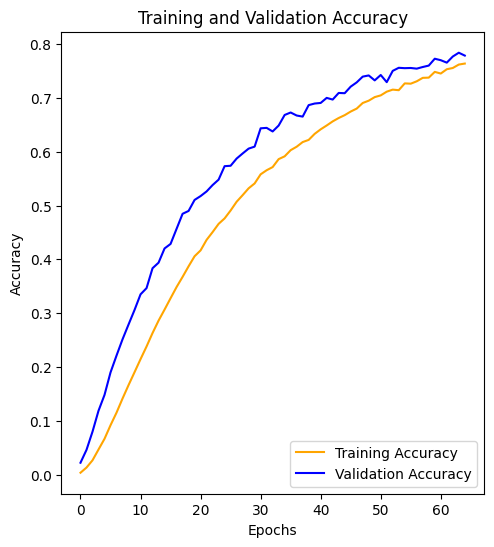

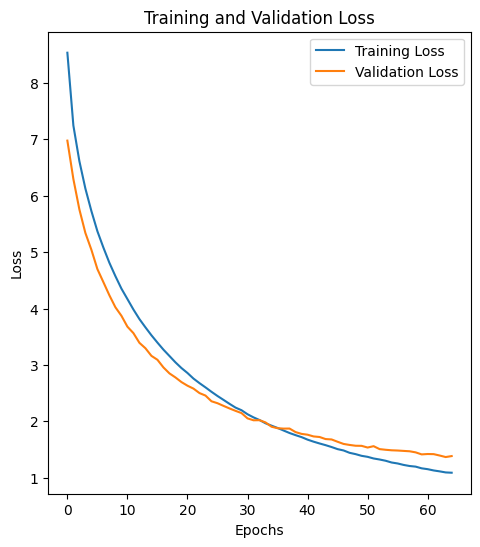

In [30]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(65)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy',color="orange")
plt.plot(epochs_range, val_acc, label='Validation Accuracy',color="blue")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [55]:
score = model.evaluate(test_ds)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
predict=model.predict(test_ds)
y_classes = predict.argmax(axis=-1)
pred = np.argmax(y_classes)
print(y_classes)

7269/7269 [==============================] - 1333s 183ms/step - loss: 1.3583 - acc: 0.7791 - sparse_categorical_accuracy: 0.7791
Test loss: 1.3583314418792725
Test accuracy: 0.7790617942810059
7269/7269 [==============================] - 1180s 162ms/step
[   0    0    0 ... 1998 1998 1998]
